In [9]:
# --- Offline simulation: probability of each action over 5 rounds (single slot) ---

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from obp.dataset import OpenBanditDataset
import plotly.graph_objects as go
from plotly.subplots import make_subplots

SEED = 7
rng = np.random.RandomState(SEED)


### Helper Functions

In [16]:
def exact_pmf_one_update(K: int, updated_arm: int, reward: int):
    """
    Closed-form TS selection probabilities when all arms start Beta(1,1),
    and exactly one arm is updated once at this position (no MC).
    """
    p = np.empty(K, dtype=float)
    if reward == 1:
        p_updated = 2.0 / (K + 1.0)              # updated arm
        p_others  = 1.0 / (K + 1.0)              # every other arm
    else:
        p_updated = 2.0 / (K * (K + 1.0))        # updated arm
        p_others  = (1.0 - p_updated) / (K - 1.) # spread remainder evenly
    p.fill(p_others)
    p[updated_arm] = p_updated
    return p

def make_probs_df(round_num: int, alpha, beta, pmf_by_pos):
    """Build a wide DataFrame for a given round with selection probs and α/β per position."""
    rows = []
    for a in range(n_actions):
        row = {"round": round_num, "action": a}
        for pos in positions:
            row[f"p_pos{pos}"]     = pmf_by_pos[pos][a]
            row[f"alpha_pos{pos}"] = alpha[pos][a]
            row[f"beta_pos{pos}"]  = beta[pos][a]
        rows.append(row)
    return pd.DataFrame(rows)

### Load the data

In [13]:

# --- Load OBD (Random / all as example) ---
ds = OpenBanditDataset(behavior_policy="random", campaign="all")
bf = ds.obtain_batch_bandit_feedback()

print("bandit_feedback keys:", bf.keys())
print(f"Rounds: {bf['n_rounds']:,} | n_actions: {bf['n_actions']} | len_list: {ds.len_list}")

# Build a DataFrame for convenience
df = pd.DataFrame({
    "action": bf["action"],
    "position": bf["position"],
    "reward": bf["reward"],
    "pscore": bf["pscore"],
})

df.head()

INFO:obp.dataset.real:When `data_path` is not given, this class downloads the small-sized version of Open Bandit Dataset.


bandit_feedback keys: dict_keys(['n_rounds', 'n_actions', 'action', 'position', 'reward', 'pscore', 'context', 'action_context'])
Rounds: 10,000 | n_actions: 80 | len_list: 3


,action,position,reward,pscore
0,14,2,0,0.0125
1,14,2,0,0.0125
2,27,2,0,0.0125
3,48,1,0,0.0125
4,36,1,0,0.0125


In [14]:
df.shape

(10000, 4)

### Every action being equally likely of being chosen

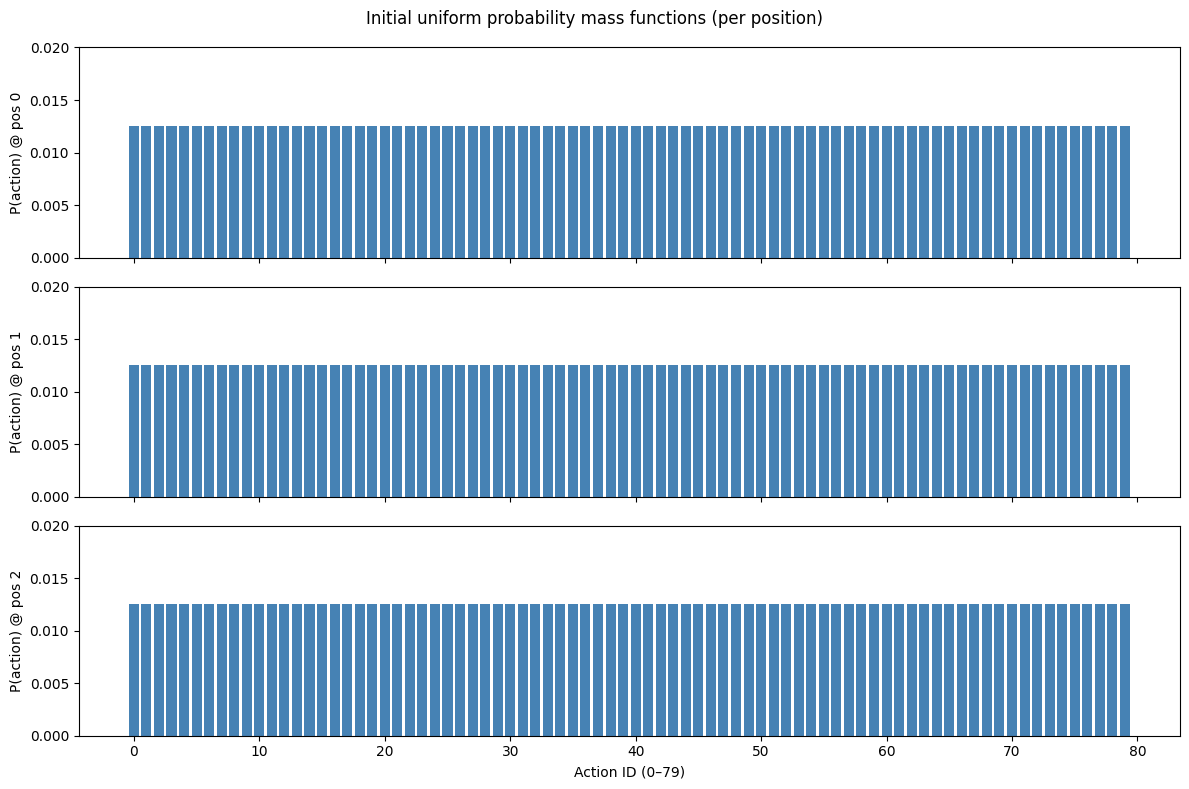

In [15]:
n_actions = bf["n_actions"]   # 80
positions = [0, 1, 2]

# Uniform PMF for each position
pmfs = {pos: np.ones(n_actions) / n_actions for pos in positions}

# Plot
fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

for pos, ax in zip(positions, axes):
    ax.bar(np.arange(n_actions), pmfs[pos], color="steelblue")
    ax.set_ylabel(f"P(action) @ pos {pos}")
    ax.set_ylim(0, 0.02)  # ~1/80 = 0.0125
axes[-1].set_xlabel("Action ID (0–79)")
fig.suptitle("Initial uniform probability mass functions (per position)")
plt.tight_layout()
plt.show()

### Round 1 

### Initialize alphas and betas

In [21]:

# ---------- Setup ----------
n_actions = bf["n_actions"]     # K=80
positions = [0, 1, 2]

# Priors: Beta(1,1) everywhere (Round 0 state)
alpha = {pos: np.ones(n_actions, dtype=float) for pos in positions}
beta  =  {pos: np.ones(n_actions, dtype=float) for pos in positions}

# ---------- Round 0: before any updates ----------
pmf_round0 = {pos: np.full(n_actions, 1.0 / n_actions) for pos in positions}  # uniform
df_round0  = make_probs_df(round_num=0, alpha=alpha, beta=beta, pmf_by_pos=pmf_round0)

### Sample Observation

In [24]:
# ---------- Sample one observation per position from your log DF ----------
# NOTE: set random_state=<int> for reproducibility; None for fresh randomness.
sampled = (
    df.groupby("position", group_keys=False)
      .apply(lambda x: x.sample(1, random_state=None))
      .reset_index(drop=True)
)
sampled

,action,position,reward,pscore
0,54,0,0,0.0125
1,34,1,0,0.0125
2,46,2,0,0.0125


### Update based on observations

In [26]:
# ---------- Round 1: apply sampled updates ----------
for _, r in sampled.iterrows():
    a_obs = int(r["action"])
    p_obs = int(r["position"])
    r_obs = int(r["reward"])
    alpha[p_obs][a_obs] += r_obs
    beta[p_obs][a_obs]  += (1 - r_obs)




# Build PMFs after the (one) update at each position (closed-form)
pmf_round1 = {}
for pos in positions:
    obs_row = sampled.loc[sampled["position"] == pos].iloc[0]
    pmf_round1[pos] = exact_pmf_one_update(
        K=n_actions,
        updated_arm=int(obs_row["action"]),
        reward=int(obs_row["reward"]),
    )

df_round1 = make_probs_df(round_num=1, alpha=alpha, beta=beta, pmf_by_pos=pmf_round1)




# ---------- Combine rounds for tracking ----------
df_probs_all_rounds = pd.concat([df_round0, df_round1], ignore_index=True)

# Peek: show just the three updated actions across rounds
updated_actions = sampled["action"].tolist()
print("\nUpdated actions across rounds:")
df_probs_all_rounds[df_probs_all_rounds["action"].isin(updated_actions)].sort_values(["round","action"])



Updated actions across rounds:


,round,action,p_pos0,alpha_pos0,beta_pos0,p_pos1,alpha_pos1,beta_pos1,p_pos2,alpha_pos2,beta_pos2
34,0,34,0.012500,1.0,1.0,0.012500,1.0,1.0,0.012500,1.0,1.0
46,0,46,0.012500,1.0,1.0,0.012500,1.0,1.0,0.012500,1.0,1.0
54,0,54,0.012500,1.0,1.0,0.012500,1.0,1.0,0.012500,1.0,1.0
114,1,34,0.012654,1.0,1.0,0.000309,1.0,3.0,0.012654,1.0,1.0
126,1,46,0.012654,1.0,1.0,0.012654,1.0,1.0,0.000309,1.0,3.0
134,1,54,0.000309,1.0,3.0,0.012654,1.0,1.0,0.012654,1.0,1.0


In [ ]:


print("Sampled (one row per position):")
print(sampled[["action","position","reward","pscore"]])

fig = make_subplots(
    rows=3, cols=1, shared_xaxes=False,   # <- don't share, so each row can show its ticks
    subplot_titles=[f"Position {p}" for p in positions],
    vertical_spacing=0.08
)

for i, pos in enumerate(positions, start=1):
    xs  = np.arange(n_actions)
    y0  = pmf_round0[pos]
    y1  = pmf_round1[pos]
    ymax = float(max(y0.max(), y1.max())) * 1.25

    fig.add_trace(
        go.Bar(
            x=xs, y=y0, name="Round 0 (uniform)",
            marker=dict(color="steelblue"),
            opacity=0.6, legendgroup="round0",
            showlegend=(i == 1),
            customdata=np.column_stack([np.full(n_actions, pos)]),
            hovertemplate="Position: %{customdata[0]}<br>Action: %{x}<br>Round: 0<br>P: %{y:.6f}<extra></extra>",
        ),
        row=i, col=1
    )

    fig.add_trace(
        go.Bar(
            x=xs, y=y1, name="Round 1 (updated)",
            marker=dict(color="darkorange"),
            opacity=0.8, legendgroup="round1",
            showlegend=(i == 1),
            customdata=np.column_stack([np.full(n_actions, pos)]),
            hovertemplate="Position: %{customdata[0]}<br>Action: %{x}<br>Round: 1<br>P: %{y:.6f}<extra></extra>",
        ),
        row=i, col=1
    )

    # per-row y range
    fig.update_yaxes(range=[0, ymax], row=i, col=1)

# force ticks 0..79 on EVERY subplot
tick_vals = np.arange(n_actions)
tick_txt  = [str(a) for a in tick_vals]
for i in range(1, 4):
    fig.update_xaxes(
        tickmode="array",
        tickvals=tick_vals,
        ticktext=tick_txt,
        showticklabels=True,   # <- ensure labels are drawn
        ticks="outside",
        row=i, col=1
    )

# axis titles
fig.update_xaxes(title_text="Action ID (0–79)", row=3, col=1)
for i in range(1, 4):
    fig.update_yaxes(title_text="P(action selected)", row=i, col=1)

fig.update_layout(
    title="Selection probabilities by position: Round 0 vs Round 1",
    barmode="group",
    bargap=0.15,
    height=900,
    template="plotly_white",
)

fig.show()

Sampled (one row per position):
   action  position  reward  pscore
0      79         0       0  0.0125
1       7         1       0  0.0125
2      49         2       0  0.0125


In [18]:
!jupyter nbconvert --to script bandit.ipynb

[NbConvertApp] Converting notebook bandit.ipynb to script
[NbConvertApp] Writing 6871 bytes to bandit.py


In [32]:
# bandit_rounds.py

import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

class ThompsonSlateTracker:
    def __init__(self, df, n_actions: int, positions=(0,1,2), seed: int = 7):
        """
        df: DataFrame with columns ['action','position','reward','pscore']
        n_actions: number of actions (e.g., 80)
        positions: iterable of slot indices present in df (0,1,2)
        """
        self.df = df
        self.n_actions = int(n_actions)
        self.positions = tuple(positions)
        self.rng = np.random.RandomState(seed)

        # priors
        self.alpha = {p: np.ones(self.n_actions, dtype=float) for p in self.positions}
        self.beta  = {p: np.ones(self.n_actions, dtype=float) for p in self.positions}

        # history
        self.round = 0
        self.pmfs = {}        # round -> {pos -> np.array(n_actions)}
        self.samples = {}     # round -> DataFrame rows (one per position)

        # round 0 snapshot (uniform PMF)
        pmf0 = {p: np.full(self.n_actions, 1.0/self.n_actions) for p in self.positions}
        self.pmfs[0] = pmf0
        self.samples[0] = pd.DataFrame(columns=["action","position","reward","pscore"])

    # ---------- PMF backends ----------
    @staticmethod
    def _pmf_exact_one_update(K: int, updated_arm: int, reward: int):
        """Exact closed-form PMF when starting from Beta(1,1) and exactly one arm updated once."""
        p = np.empty(K, dtype=float)
        if reward == 1:
            p_updated = 2.0 / (K + 1.0)
            p_others  = 1.0 / (K + 1.0)
        else:
            p_updated = 2.0 / (K * (K + 1.0))
            p_others  = (1.0 - p_updated) / (K - 1.0)
        p.fill(p_others)
        p[updated_arm] = p_updated
        return p

    @staticmethod
    def _pmf_mc(alpha_vec, beta_vec, n_sim=200_000, rng=None):
        """Monte Carlo PMF: P(action = argmax) for one position."""
        rng = np.random.RandomState() if rng is None else rng
        K = len(alpha_vec)
        samples = rng.beta(alpha_vec[None, :], beta_vec[None, :], size=(n_sim, K))
        winners = samples.argmax(axis=1)
        counts = np.bincount(winners, minlength=K)
        return counts / counts.sum()

    def _can_use_exact(self, pos: int, samples_this_round: pd.DataFrame):
        """Exact is valid iff all actions at this pos are Beta(1,1) except possibly ONE with a single +/-1 update."""
        # Check α,β before applying new updates? We call this AFTER updates for the round,
        # but only exact if the *cumulative* state at this pos is either:
        # - all ones (no updates), or
        # - exactly one action has (alpha,beta) in {(2,1),(1,2)} and everyone else is (1,1)
        a = self.alpha[pos]; b = self.beta[pos]
        mask_ones = (a == 1) & (b == 1)
        if mask_ones.all():
            return True, None, None  # uniform exact
        # find candidates with one step changes
        changed_idx = np.where(~mask_ones)[0]
        if len(changed_idx) != 1:
            return False, None, None
        j = int(changed_idx[0])
        pair = (a[j], b[j])
        if (pair == (2,1)) or (pair == (1,2)):
            # also ensure all others are (1,1)
            return True, j, int(pair[0] == 2 and pair[1] == 1)  # reward=1 if (2,1)
        return False, None, None

    # ---------- Round operations ----------
    def sample_one_per_position(self, random_state=None):
        """Return 3-row DataFrame with one random row per position."""
        samp = (
            self.df.groupby("position", group_keys=False)
            .apply(lambda x: x.sample(1, random_state=random_state))
            .reset_index(drop=True)
        )
        return samp

    def apply_updates(self, sampled_rows: pd.DataFrame):
        """Update alpha/beta using the sampled rows."""
        for _, r in sampled_rows.iterrows():
            a_obs = int(r["action"])
            p_obs = int(r["position"])
            r_obs = int(r["reward"])
            self.alpha[p_obs][a_obs] += r_obs
            self.beta[p_obs][a_obs]  += (1 - r_obs)

    def snapshot_pmfs(self, use_mc_if_needed=True, n_sim=200_000):
        """Compute PMF for every position given current alpha/beta; store under current round."""
        pmf = {}
        for pos in self.positions:
            ok_exact, idx, rew = self._can_use_exact(pos, None)
            if ok_exact:
                if idx is None:
                    # truly uniform
                    pmf[pos] = np.full(self.n_actions, 1.0/self.n_actions, dtype=float)
                else:
                    pmf[pos] = self._pmf_exact_one_update(self.n_actions, idx, rew)
            else:
                if not use_mc_if_needed:
                    raise RuntimeError(
                        f"Exact closed-form is not valid at position {pos} after round {self.round}. "
                        "Set use_mc_if_needed=True (default) to compute PMFs."
                    )
                pmf[pos] = self._pmf_mc(self.alpha[pos], self.beta[pos], n_sim=n_sim, rng=self.rng)
        self.pmfs[self.round] = pmf

    def next_round(self, random_state=None, use_mc_if_needed=True, n_sim=200_000):
        """Advance one round: sample, update, snapshot PMFs."""
        self.round += 1
        samp = self.sample_one_per_position(random_state=random_state)
        self.samples[self.round] = samp
        self.apply_updates(samp)
        self.snapshot_pmfs(use_mc_if_needed=use_mc_if_needed, n_sim=n_sim)
        return samp  # useful to print/inspect

    # ---------- Plot ----------
    def plot_compare(self, round_a: int, round_b: int, height=900, title=None):
        """Plotly grouped bars comparing PMFs of two rounds for each position."""
        if round_a not in self.pmfs or round_b not in self.pmfs:
            raise KeyError("Requested rounds not in history. Call snapshot/next_round first.")

        pmf_a = self.pmfs[round_a]
        pmf_b = self.pmfs[round_b]
        n_actions = self.n_actions

        fig = make_subplots(
            rows=3, cols=1, shared_xaxes=False,
            subplot_titles=[f"Position {p}" for p in self.positions],
            vertical_spacing=0.08
        )

        for i, pos in enumerate(self.positions, start=1):
            xs = np.arange(n_actions)
            yA = pmf_a[pos]
            yB = pmf_b[pos]
            ymax = float(max(yA.max(), yB.max())) * 1.25

            fig.add_trace(
                go.Bar(
                    x=xs, y=yA, name=f"Round {round_a}",
                    marker=dict(color="steelblue"), opacity=0.6,
                    showlegend=(i == 1),
                    customdata=np.column_stack([np.full(n_actions, pos)]),
                    hovertemplate="Position: %{customdata[0]}<br>Action: %{x}<br>Round: "+str(round_a)+"<br>P: %{y:.6f}<extra></extra>",
                ),
                row=i, col=1
            )
            fig.add_trace(
                go.Bar(
                    x=xs, y=yB, name=f"Round {round_b}",
                    marker=dict(color="darkorange"), opacity=0.8,
                    showlegend=(i == 1),
                    customdata=np.column_stack([np.full(n_actions, pos)]),
                    hovertemplate="Position: %{customdata[0]}<br>Action: %{x}<br>Round: "+str(round_b)+"<br>P: %{y:.6f}<extra></extra>",
                ),
                row=i, col=1
            )
            fig.update_yaxes(range=[0, ymax], row=i, col=1)

        # force ticks 0..n_actions-1 on all three subplots
        ticks = np.arange(n_actions)
        labels = [str(a) for a in ticks]
        for i in range(1, 4):
            fig.update_xaxes(
                tickmode="array", tickvals=ticks, ticktext=labels,
                showticklabels=True, ticks="outside",
                row=i, col=1
            )

        fig.update_xaxes(title_text="Action ID (0–79)", row=3, col=1)
        for i in range(1, 4):
            fig.update_yaxes(title_text="P(action selected)", row=i, col=1)

        fig.update_layout(
            title=title or f"Selection probabilities by position: Round {round_a} vs Round {round_b}",
            barmode="group", bargap=0.15, height=height, template="plotly_white"
        )
        fig.show()

In [34]:
# Assumes you already built df (action, position, reward, pscore) and bf for n_actions
tracker = ThompsonSlateTracker(df=df, n_actions=bf["n_actions"], positions=[0,1,2], seed=7)

# Round 0 is already recorded (uniform)
# Take Round 1 (samples per position, updates α/β, stores PMFs)
samp1 = tracker.next_round(random_state=None, use_mc_if_needed=False)  # exact is valid here
print("Round 1 samples:\n", samp1)

# Plot Round 0 vs Round 1
tracker.plot_compare(0, 1, title="Round 0 vs Round 1")

# Take Round 2 (now exact may be invalid; allow MC to compute PMFs)
samp2 = tracker.next_round(random_state=None, use_mc_if_needed=True)   # enables MC fallback
print("Round 2 samples:\n", samp2)

# Plot Round 1 vs Round 2
tracker.plot_compare(1, 2, title="Round 1 vs Round 2")

Round 1 samples:
    action  position  reward  pscore
0      28         0       0  0.0125
1      61         1       0  0.0125
2      13         2       0  0.0125


Round 2 samples:
    action  position  reward  pscore
0      23         0       0  0.0125
1       7         1       0  0.0125
2      18         2       1  0.0125
